# Adding Geographic Information to Files
#### Jameson Carter, Mihir Bhaskar, Abhilash Biswas
#### 11/30/2021
The following code edits our combined file by adding geographic features to enrich our dataset.

In this file, we-
 - Add proximity analyses of railroads https://koordinates.com/layer/96346-chicago-illinois-railroads/data/
 - Add proximity analyses of waterways https://data.cityofchicago.org/Parks-Recreation/Waterways/eg9f-z3t6
 - Add proximity analyses of highways https://data.cityofchicago.org/Transportation/Major-Streets/ueqs-5wr6

## Import Geographic Features

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
from pyprojroot import here
import seaborn as sns
%matplotlib inline
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [128]:
railroads = gpd.read_file(here('./data/raw/chicago-illinois-railroads.shp'))
combined = pd.read_csv(here('./data/CleanACSFile.csv'))
waterways = gpd.read_file(here('./data/raw/waterways.shp'))
majorStreets = gpd.read_file(here('./data/raw/Major_Streets.shp'))

### Bring in geographic features and standardize CRS
In order to ensure these files overlay correctly, we must check their coordinate reference systems. This will allow us to trust that the spatial joins we run are accurate. https://geopandas.org/en/stable/docs/user_guide/projections.html

In [129]:
combined['geometry'] = gpd.GeoSeries.from_wkt(combined['geometry'])
GeoData = gpd.GeoDataFrame(combined, geometry='geometry', crs='epsg:4326')

In [130]:
railroads['geometry'] = railroads['geometry'].to_crs(epsg='3035')

In [131]:
waterways['geometry'] = waterways['geometry'].to_crs(epsg='3035')

In [132]:
majorStreets['geometry'] = majorStreets['geometry'].to_crs(epsg='3035')

In [133]:
majorStreets.crs == waterways.crs == railroads.crs

True

In [134]:
waterways.drop_duplicates(['name'])

,display,edit_date1,fid_,name,shape_area,shape_len,geometry
0,0.0,03-23-01,None,None,1.775668e+04,6.643216e+02,"POLYGON ((-1194023.861 6856311.182, -1194023.7..."
1,0.0,03-23-01,None,SANITARY AND SHIP CANAL,9.774484e+05,7.119384e+03,"POLYGON ((-1194074.531 6854210.851, -1194120.4..."
4,1.0,03-23-01,None,SOUTH BRANCH CHICAGO RIVER,7.238918e+03,4.342960e+02,"POLYGON ((-1194243.534 6853175.011, -1194246.9..."
69,1.0,03-23-01,None,CHICAGO RIVER,2.095512e+04,5.993067e+02,"POLYGON ((-1188939.610 6851241.643, -1188942.4..."
96,0.0,03-23-01,None,LITTLE CALUMET RIVER,2.889686e+07,8.240906e+04,"POLYGON ((-1211041.544 6841828.911, -1211022.8..."
128,1.0,03-23-01,None,CALUMET RIVER,9.491982e+03,7.473737e+02,"POLYGON ((-1212303.666 6837800.039, -1212310.3..."
152,0.0,03-23-01,None,NORTH BRANCH CHICAGO RIVER,4.070189e+05,1.638412e+04,"POLYGON ((-1177653.587 6868819.038, -1177660.5..."
204,1.0,03-23-01,None,NORTH SHORE CHANNEL,1.054503e+04,5.336776e+02,"POLYGON ((-1178153.228 6862574.927, -1178129.7..."
221,1.0,03-23-01,None,DES PLAINES RIVER,7.817665e+03,4.309135e+02,"POLYGON ((-1179179.374 6874873.775, -1179188.4..."
290,4.0,10-14-05,None,LAKE MICHIGAN,2.097687e+11,2.063229e+06,"MULTIPOLYGON (((-1068336.367 6916066.671, -106..."


In [135]:
# let's do buffers around lake michigan and the rivers/canals
lakemichigan = waterways[(waterways['name']== 'LAKE MICHIGAN')].copy()
rivers_canals = waterways[(waterways['name']== 'SOUTH BRANCH CHICAGO RIVER') | (waterways['name'] == 'CHICAGO RIVER')|
                          (waterways['name'] == 'SANITARY AND SHIP CANAL') | (waterways['name'] == 'LITTLE CALUMET RIVER')|
                          (waterways['name'] == 'CALUMET RIVER') | (waterways['name'] == 'DES PLAINES RIVER')|
                          (waterways['name'] == 'NORTH BRANCH CHICAGO RIVER') | (waterways['name'] == 'NORTH SHORE CHANNEL')].copy()

### Generate Buffers Around Railroads, Major Streets, Lake Michigan, Rivers and Canals
The following code generates buffers around geographic features to see which Census Tracts are within a quarter mile of each feature. Through this we can enrich our data further to see which tracts are particularly close to potentially important geographic features.

<AxesSubplot:>

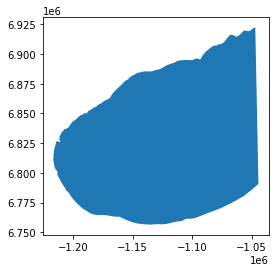

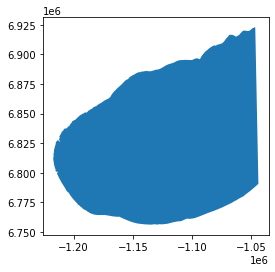

In [136]:
# calculating distance from each census tract centroid to each
buffer_length_in_meters = (0.25 * 1000) * 1.60934
lakemichigan.plot()
lakemichigan['geometry'] = lakemichigan.geometry.buffer(buffer_length_in_meters)
lakemichigan.plot() # plot to ensure buffer was calculated.

<AxesSubplot:>

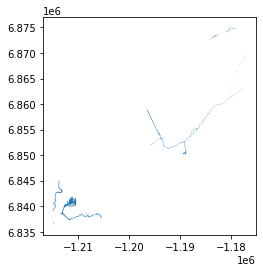

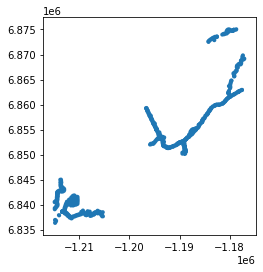

In [137]:
# calculating distance from each census tract centroid to each
rivers_canals.plot() 
rivers_canals['geometry'] = rivers_canals.geometry.buffer(buffer_length_in_meters)
rivers_canals.plot() # plot to ensure buffer was calculated.

Now evaluate class 1 roads

<AxesSubplot:>

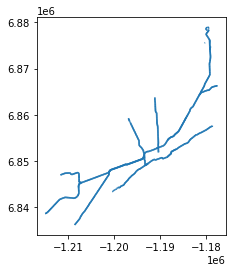

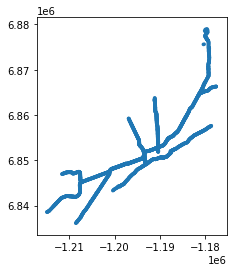

In [138]:
class1roads = majorStreets[majorStreets['CLASS']=='1'].copy()
# calculating distance from each census tract centroid to each
class1roads.plot() 
class1roads['geometry'] = class1roads.geometry.buffer(buffer_length_in_meters)
class1roads.plot() # plot to ensure buffer was calculated.

The following exploration finds that the typical tract (as defined by the median), exhibits no complaints, while the average tract exhibits 0.83 complaints.

<AxesSubplot:>

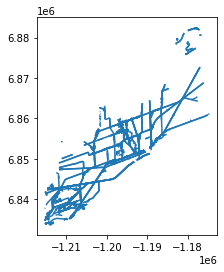

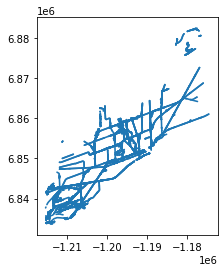

In [139]:
railroads.plot()
# calculating distance from each census tract centroid to each, set to eigth of mile
railroads['geometry'] = railroads.geometry.buffer((0.125 * 1000) * 1.60934)
railroads.plot() # plot to ensure buffer was calculated.

### Merging Buffers With Census Tracts
This step merges the buffered features with Census Tracts to see which tracts are within a quarter mile (eigth of a mile in case of railroads) of each feature.

In [140]:
class1roads['geometry'] = class1roads['geometry'].to_crs(epsg='4326')
print(class1roads.crs == GeoData.crs)

joined_dataframe = gpd.sjoin(GeoData, class1roads[['geometry', 'CLASS']], how = 'inner')

True


<AxesSubplot:>

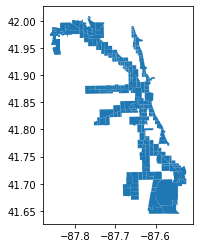

In [141]:
datRoads = joined_dataframe.drop(['CLASS', 'index_right'], axis = 1).drop_duplicates()
datRoads['MajorRd_qmile'] = 1

datRoads.plot()

True


<AxesSubplot:>

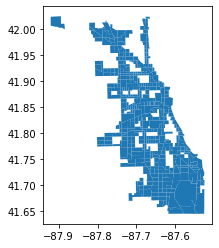

In [142]:
railroads['geometry'] = railroads['geometry'].to_crs(epsg='4326')
print(railroads.crs == GeoData.crs)

joined_dataframe = gpd.sjoin(GeoData, railroads[['geometry', 'RAILROAD']], how = 'inner')
datRail = joined_dataframe.drop(['RAILROAD', 'index_right'], axis = 1).drop_duplicates()
datRail['Rail_emile'] = 1

datRail.plot()

True


<AxesSubplot:>

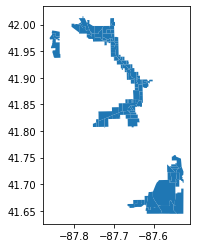

In [143]:
rivers_canals['geometry'] = rivers_canals['geometry'].to_crs(epsg='4326')
print(rivers_canals.crs == GeoData.crs)

joined_dataframe = gpd.sjoin(GeoData, rivers_canals[['geometry', 'name']], how = 'inner')
datRivers = joined_dataframe.drop(['name', 'index_right'], axis = 1).drop_duplicates()
datRivers['river_qmile'] = 1

datRivers.plot()

True


<AxesSubplot:>

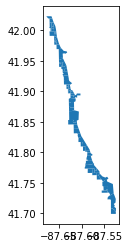

In [144]:
lakemichigan['geometry'] = lakemichigan['geometry'].to_crs(epsg='4326')
print(lakemichigan.crs == GeoData.crs)

joined_dataframe = gpd.sjoin(GeoData, lakemichigan[['geometry', 'name']], how = 'inner')
datLakeMI = joined_dataframe.drop(['name', 'index_right'], axis = 1).drop_duplicates()
datLakeMI['lakeMI_qmile'] = 1

datLakeMI.plot()

In [146]:
datLakeMI = datLakeMI[['geo_id','lakeMI_qmile']].copy()
datRivers = datRivers[['geo_id','river_qmile']].copy()
datRail = datRail[['geo_id','Rail_emile']].copy()
datRoads = datRoads[['geo_id','MajorRd_qmile']].copy()

GeoData = GeoData.merge(datLakeMI, on = 'geo_id', how = 'left')
GeoData = GeoData.merge(datRivers, on = 'geo_id', how = 'left')
GeoData = GeoData.merge(datRail, on = 'geo_id', how = 'left')
GeoData = GeoData.merge(datRoads, on = 'geo_id', how = 'left')

GeoData.fillna(0, inplace = True)
GeoData

,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,...,number_of_police_killings,total_violent_crimes,total_non_violent_crimes,total_property_crimes,total_other_crimes,inv_stop_count,lakeMI_qmile,river_qmile,Rail_emile,MajorRd_qmile
0,1400000US17031010100,4599.0,23.8,2.5,39.5,34.2,21.5,8.7,1.89,25.4,...,0.0,1039,417,1240,198,3.0,1.0,0.0,1.0,0.0
1,1400000US17031010201,7455.0,33.7,7.2,28.3,30.8,28.2,14.9,2.65,34.5,...,0.0,801,225,942,138,18.0,0.0,0.0,1.0,0.0
2,1400000US17031010202,2896.0,23.1,13.6,23.0,40.4,26.9,17.9,2.27,25.1,...,0.0,822,217,1081,77,16.0,0.0,0.0,1.0,0.0
3,1400000US17031010300,6485.0,25.3,7.4,25.2,42.1,17.0,18.7,1.80,20.0,...,0.0,663,209,891,129,9.0,1.0,0.0,0.0,0.0
4,1400000US17031010400,5213.0,17.4,5.7,36.4,40.5,12.5,10.7,1.82,16.8,...,0.0,461,212,602,97,39.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,1400000US17031843500,10169.0,33.0,22.8,25.6,18.6,50.9,10.2,3.58,44.1,...,0.0,528,212,763,133,40.0,0.0,1.0,1.0,1.0
794,1400000US17031843600,2898.0,12.5,8.8,18.9,59.7,28.4,20.9,2.06,32.5,...,0.0,671,238,783,132,35.0,0.0,0.0,0.0,0.0
795,1400000US17031843700,2527.0,51.3,5.6,17.9,25.1,39.6,22.4,2.55,32.6,...,1.0,296,196,608,76,77.0,0.0,1.0,0.0,0.0
796,1400000US17031843800,1520.0,19.8,9.5,31.9,38.8,32.4,32.5,2.23,31.1,...,0.0,643,231,642,131,41.0,0.0,0.0,1.0,1.0


In [147]:
FinalGeo = GeoData[['geo_id', 'lakeMI_qmile', 'river_qmile', 'Rail_emile', 'MajorRd_qmile']]

In [149]:
FinalGeo.to_csv(here('./data/CleanGeoFile.csv'), index = False)

C:\Users\jacar\anaconda3\lib\site-packages\pyprojroot\pyprojroot.py:51: UserWarning: Path doesn't exist: C:\Users\jacar\OneDrive\Documents\chicago-complaints\data\CleanGeoFile.csv
  warnings.warn("Path doesn't exist: {}".format(path))


## Sources

 - https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
 - The in class exercise Clustering-Mini2_JamsonCarter.ipynb
 - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
 - https://stackoverflow.com/questions/38372188/how-to-add-k-means-predicted-clusters-in-a-column-to-a-dataframe-in-python
 - https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
 - https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns